# Ensemble Methods: Stacking and Voting

## Overview

**Ensemble learning** combines multiple models to create a stronger predictor than any individual model.

### Core Idea

*"The wisdom of crowds"* - Multiple diverse models making predictions together often outperform a single model.

### Types of Ensemble Methods

```
Ensemble Methods
├── Bagging (Bootstrap Aggregating)
│   └── Random Forest, Bagging Classifier/Regressor
├── Boosting
│   └── AdaBoost, Gradient Boosting, XGBoost, LightGBM
└── Stacking & Voting (This notebook)
    ├── Voting: Simple combination of predictions
    └── Stacking: Meta-model learns optimal combination
```

## Topics Covered

### 1. Voting Ensembles
- Hard voting (majority vote for classification)
- Soft voting (average probabilities)
- Voting for regression (average predictions)
- When voting works best

### 2. Stacking Ensembles
- Two-level architecture (base models + meta-model)
- Cross-validation predictions
- Preventing overfitting in stacking
- Feature augmentation strategies

### 3. Practical Applications
- Classification tasks
- Regression tasks
- Model diversity importance
- Hyperparameter tuning for ensembles

### 4. Comparison and Best Practices
- When to use voting vs stacking
- Computational considerations
- Interpretability tradeoffs

## Setup and Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Models
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    VotingClassifier, VotingRegressor,
    StackingClassifier, StackingRegressor
)
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

# Utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.datasets import (
    load_breast_cancer, load_wine, load_iris,
    load_diabetes, make_classification, make_regression
)

np.random.seed(42)
sns.set_style('whitegrid')
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Ensemble Learning Fundamentals

### 1.1 Why Ensembles Work

**Key Principle**: If individual models make **different** errors, combining them reduces overall error.

**Requirements for Effective Ensembles**:
1. **Diversity**: Models should be different (different algorithms, hyperparameters, or training data)
2. **Accuracy**: Base models should be better than random guessing
3. **Independence**: Models should make uncorrelated errors

### Mathematical Intuition

**Example**: Binary classification with 3 classifiers, each 70% accurate.

**Majority voting probability of being correct**:
\[
P(\text{correct}) = P(\text{all 3 correct}) + P(\text{exactly 2 correct})
\]
\[
= (0.7)^3 + 3 \times (0.7)^2 \times (0.3) = 0.343 + 0.441 = 0.784
\]

**Result**: 78.4% ensemble accuracy vs 70% individual accuracy!

*(Assumes independence - real models may be correlated)*

In [2]:
print("Ensemble Voting Mathematics")
print("="*70)

# Simulate voting with different base accuracies
def voting_accuracy(base_acc, n_models):
    """Calculate expected accuracy of majority voting."""
    from math import comb
    # Need at least (n_models // 2 + 1) models to be correct
    threshold = n_models // 2 + 1
    prob_correct = 0
    for k in range(threshold, n_models + 1):
        prob_correct += comb(n_models, k) * (base_acc ** k) * ((1 - base_acc) ** (n_models - k))
    return prob_correct

# Test different scenarios
base_accuracies = [0.6, 0.65, 0.7, 0.75, 0.8]
n_models_list = [3, 5, 7, 9]

print("Expected Ensemble Accuracy (Majority Voting)")
print("Assumes models make independent errors\n")

results = []
for base_acc in base_accuracies:
    row = {'Base Accuracy': f"{base_acc:.2f}"}
    for n in n_models_list:
        ensemble_acc = voting_accuracy(base_acc, n)
        row[f'{n} Models'] = f"{ensemble_acc:.3f}"
        if n == 3:
            row['Improvement'] = f"+{(ensemble_acc - base_acc)*100:.1f}%"
    results.append(row)

df = pd.DataFrame(results)
print(df.to_string(index=False))

print("\n💡 Key Insights:")
print("   - More models → Better ensemble accuracy")
print("   - Better base models → Better ensembles")
print("   - Diminishing returns with too many models")
print("   - Real ensembles: models are correlated (less improvement)")

Ensemble Voting Mathematics
Expected Ensemble Accuracy (Majority Voting)
Assumes models make independent errors

Base Accuracy 3 Models Improvement 5 Models 7 Models 9 Models
         0.60    0.648       +4.8%    0.683    0.710    0.733
         0.65    0.718       +6.8%    0.765    0.800    0.828
         0.70    0.784       +8.4%    0.837    0.874    0.901
         0.75    0.844       +9.4%    0.896    0.929    0.951
         0.80    0.896       +9.6%    0.942    0.967    0.980

💡 Key Insights:
   - More models → Better ensemble accuracy
   - Better base models → Better ensembles
   - Diminishing returns with too many models
   - Real ensembles: models are correlated (less improvement)


## 2. Voting Classifier

### Concept

**Voting Classifier** combines predictions from multiple models using:

1. **Hard Voting**: Majority vote (mode of predictions)
   \[
   \hat{y} = \text{mode}(\hat{y}_1, \hat{y}_2, ..., \hat{y}_n)
   \]

2. **Soft Voting**: Average of predicted probabilities (often better)
   \[
   \hat{y} = \arg\max_c \frac{1}{n}\sum_{i=1}^{n} P_i(y=c)
   \]

### 2.1 Simple Example with Diverse Models

In [3]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print("Voting Classifier Demo - Breast Cancer Dataset")
print("="*70)
print(f"Samples: {X_cancer.shape[0]}")
print(f"Features: {X_cancer.shape[1]}")
print(f"Classes: {cancer.target_names}")

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Voting Classifier Demo - Breast Cancer Dataset
Samples: 569
Features: 30
Classes: ['malignant' 'benign']

Train set: 455 samples
Test set: 114 samples


In [4]:
# Define diverse base models
print("\nTraining Individual Models...")
print("="*70)

# Create diverse models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate individual models
individual_results = []

for name, model in models.items():
    # Train
    start_time = time()
    model.fit(X_train_scaled, y_train)
    train_time = time() - start_time
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    individual_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Train Time (s)': train_time
    })
    
    print(f"{name:20} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {train_time:.3f}s")

individual_df = pd.DataFrame(individual_results)
print("\n" + individual_df.to_string(index=False))


Training Individual Models...
Logistic Regression  - Accuracy: 0.9825, F1: 0.9861, Time: 0.189s
Random Forest        - Accuracy: 0.9561, F1: 0.9655, Time: 0.281s
SVM                  - Accuracy: 0.9825, F1: 0.9861, Time: 0.015s
KNN                  - Accuracy: 0.9561, F1: 0.9655, Time: 0.000s
Naive Bayes          - Accuracy: 0.9298, F1: 0.9444, Time: 0.002s

              Model  Accuracy  Precision   Recall  F1-Score  Train Time (s)
Logistic Regression  0.982456   0.986111 0.986111  0.986111        0.189471
      Random Forest  0.956140   0.958904 0.972222  0.965517        0.280888
                SVM  0.982456   0.986111 0.986111  0.986111        0.014927
                KNN  0.956140   0.958904 0.972222  0.965517        0.000256
        Naive Bayes  0.929825   0.944444 0.944444  0.944444        0.001639


In [5]:
# Create voting ensembles
print("\n\nCreating Voting Ensembles...")
print("="*70)

# Prepare estimators for voting
estimators = [(name, model) for name, model in models.items()]

# Hard voting
voting_hard = VotingClassifier(
    estimators=estimators,
    voting='hard'
)

start_time = time()
voting_hard.fit(X_train_scaled, y_train)
hard_train_time = time() - start_time

y_pred_hard = voting_hard.predict(X_test_scaled)
hard_accuracy = accuracy_score(y_test, y_pred_hard)
hard_f1 = f1_score(y_test, y_pred_hard)

print(f"Hard Voting - Accuracy: {hard_accuracy:.4f}, F1: {hard_f1:.4f}, Time: {hard_train_time:.3f}s")

# Soft voting
voting_soft = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

start_time = time()
voting_soft.fit(X_train_scaled, y_train)
soft_train_time = time() - start_time

y_pred_soft = voting_soft.predict(X_test_scaled)
soft_accuracy = accuracy_score(y_test, y_pred_soft)
soft_f1 = f1_score(y_test, y_pred_soft)

print(f"Soft Voting - Accuracy: {soft_accuracy:.4f}, F1: {soft_f1:.4f}, Time: {soft_train_time:.3f}s")

# Compare with best individual model
best_individual = individual_df.loc[individual_df['Accuracy'].idxmax()]

print(f"\n{'='*70}")
print("Comparison Summary:")
print(f"{'='*70}")
print(f"Best Individual Model: {best_individual['Model']} ({best_individual['Accuracy']:.4f})")
print(f"Hard Voting:           {hard_accuracy:.4f} ({'+' if hard_accuracy > best_individual['Accuracy'] else ''}{(hard_accuracy - best_individual['Accuracy'])*100:.2f}%)")
print(f"Soft Voting:           {soft_accuracy:.4f} ({'+' if soft_accuracy > best_individual['Accuracy'] else ''}{(soft_accuracy - best_individual['Accuracy'])*100:.2f}%)")

print("\n💡 Soft voting typically performs better by using probability information!")



Creating Voting Ensembles...
Hard Voting - Accuracy: 0.9737, F1: 0.9793, Time: 0.633s
Soft Voting - Accuracy: 0.9649, F1: 0.9726, Time: 0.453s

Comparison Summary:
Best Individual Model: Logistic Regression (0.9825)
Hard Voting:           0.9737 (-0.88%)
Soft Voting:           0.9649 (-1.75%)

💡 Soft voting typically performs better by using probability information!


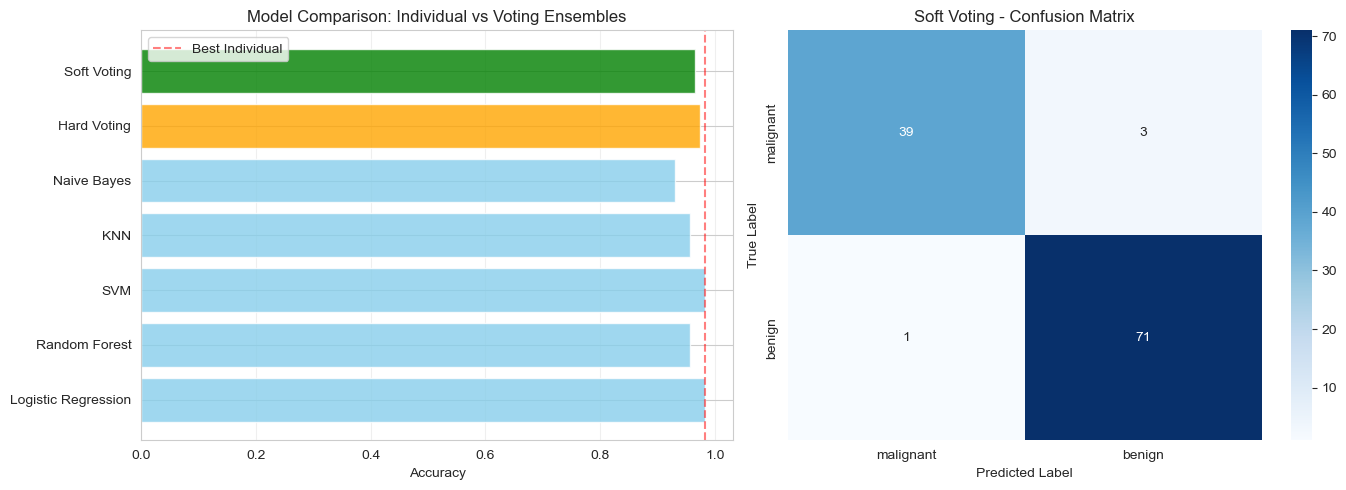

In [6]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
all_models = list(models.keys()) + ['Hard Voting', 'Soft Voting']
all_accuracies = individual_df['Accuracy'].tolist() + [hard_accuracy, soft_accuracy]
colors = ['skyblue'] * len(models) + ['orange', 'green']

axes[0].barh(all_models, all_accuracies, color=colors, alpha=0.8)
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Comparison: Individual vs Voting Ensembles')
axes[0].axvline(x=best_individual['Accuracy'], color='red', linestyle='--', 
                alpha=0.5, label='Best Individual')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='x')

# Confusion matrix for soft voting
cm = confusion_matrix(y_test, y_pred_soft)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer.target_names,
            yticklabels=cancer.target_names,
            ax=axes[1])
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_title('Soft Voting - Confusion Matrix')

plt.tight_layout()
plt.show()

## 3. Voting Regressor

### Concept

**Voting Regressor** averages predictions from multiple regression models:

\[
\hat{y} = \frac{1}{n}\sum_{i=1}^{n} \hat{y}_i
\]

Or weighted average:
\[
\hat{y} = \sum_{i=1}^{n} w_i \hat{y}_i \quad \text{where} \quad \sum w_i = 1
\]

### 3.1 Regression Example

In [7]:
# Load diabetes dataset
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

print("Voting Regressor Demo - Diabetes Dataset")
print("="*70)
print(f"Samples: {X_diabetes.shape[0]}")
print(f"Features: {X_diabetes.shape[1]}")

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_diabetes, y_diabetes, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train_reg.shape[0]} samples")
print(f"Test set: {X_test_reg.shape[0]} samples")

Voting Regressor Demo - Diabetes Dataset
Samples: 442
Features: 10

Train set: 353 samples
Test set: 89 samples


In [8]:
# Define regression models
print("\nTraining Regression Models...")
print("="*70)

reg_models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

# Train and evaluate
reg_results = []

for name, model in reg_models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    
    reg_results.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R² Score': r2
    })
    
    print(f"{name:20} - R²: {r2:.4f}, MSE: {mse:.2f}, MAE: {mae:.2f}")

reg_df = pd.DataFrame(reg_results)

# Create voting regressor
print("\n\nCreating Voting Regressor...")
print("="*70)

voting_reg = VotingRegressor(
    estimators=[(name, model) for name, model in reg_models.items()]
)

voting_reg.fit(X_train_reg, y_train_reg)
y_pred_voting = voting_reg.predict(X_test_reg)

voting_mse = mean_squared_error(y_test_reg, y_pred_voting)
voting_mae = mean_absolute_error(y_test_reg, y_pred_voting)
voting_r2 = r2_score(y_test_reg, y_pred_voting)

print(f"Voting Regressor - R²: {voting_r2:.4f}, MSE: {voting_mse:.2f}, MAE: {voting_mae:.2f}")

# Compare
best_individual_reg = reg_df.loc[reg_df['R² Score'].idxmax()]

print(f"\n{'='*70}")
print("Comparison:")
print(f"Best Individual: {best_individual_reg['Model']} (R² = {best_individual_reg['R² Score']:.4f})")
print(f"Voting Ensemble: R² = {voting_r2:.4f} ({'+' if voting_r2 > best_individual_reg['R² Score'] else ''}{(voting_r2 - best_individual_reg['R² Score']):.4f})")


Training Regression Models...
Ridge                - R²: 0.4192, MSE: 3077.42, MAE: 46.14
Random Forest        - R²: 0.4428, MSE: 2952.01, MAE: 44.05
Gradient Boosting    - R²: 0.4529, MSE: 2898.44, MAE: 44.60
KNN                  - R²: 0.4302, MSE: 3019.08, MAE: 42.77


Creating Voting Regressor...
Voting Regressor - R²: 0.4885, MSE: 2710.17, MAE: 42.54

Comparison:
Best Individual: Gradient Boosting (R² = 0.4529)
Voting Ensemble: R² = 0.4885 (+0.0355)


## 4. Stacking (Stacked Generalization)

### Concept

**Stacking** is a more sophisticated ensemble method that uses a **meta-model** to learn how to best combine base model predictions.

### Architecture

```
Level 0 (Base Models):        Level 1 (Meta-Model):
┌──────────────┐
│   Model 1    │──┐
└──────────────┘  │
┌──────────────┐  │           ┌──────────────┐
│   Model 2    │──┼──────────→│ Meta-Model   │──→ Final Prediction
└──────────────┘  │           └──────────────┘
┌──────────────┐  │
│   Model 3    │──┘
└──────────────┘
```

### Process

1. **Split training data** into folds (cross-validation)
2. **Train base models** on each fold
3. **Generate meta-features**: Base model predictions on held-out data
4. **Train meta-model** on meta-features
5. **Predict**: Base models → Meta-model → Final prediction

### Key Differences from Voting

| Aspect | Voting | Stacking |
|--------|--------|----------|
| Combination | Fixed (average/vote) | Learned by meta-model |
| Complexity | Simple | More complex |
| Performance | Good | Often better |
| Overfitting Risk | Low | Higher (needs CV) |
| Interpretability | High | Lower |

### 4.1 Stacking Classifier

In [9]:
print("Stacking Classifier Demo")
print("="*70)

# Define base models (level 0)
base_models = [
    ('lr', LogisticRegression(max_iter=10000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Define meta-model (level 1)
meta_model = LogisticRegression(max_iter=10000, random_state=42)

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # Cross-validation folds for generating meta-features
    stack_method='auto',  # Use predict_proba if available
    n_jobs=-1
)

print("Base Models (Level 0):")
for name, model in base_models:
    print(f"  - {name}: {model.__class__.__name__}")

print(f"\nMeta-Model (Level 1): {meta_model.__class__.__name__}")
print(f"Cross-validation folds: 5")

# Train stacking classifier
print("\nTraining Stacking Classifier...")
start_time = time()
stacking_clf.fit(X_train_scaled, y_train)
stacking_train_time = time() - start_time

# Predict
y_pred_stacking = stacking_clf.predict(X_test_scaled)

# Evaluate
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
stacking_precision = precision_score(y_test, y_pred_stacking)
stacking_recall = recall_score(y_test, y_pred_stacking)
stacking_f1 = f1_score(y_test, y_pred_stacking)

print(f"\nStacking Classifier Results:")
print(f"  Accuracy:  {stacking_accuracy:.4f}")
print(f"  Precision: {stacking_precision:.4f}")
print(f"  Recall:    {stacking_recall:.4f}")
print(f"  F1-Score:  {stacking_f1:.4f}")
print(f"  Train Time: {stacking_train_time:.3f}s")

Stacking Classifier Demo
Base Models (Level 0):
  - lr: LogisticRegression
  - rf: RandomForestClassifier
  - svm: SVC
  - knn: KNeighborsClassifier

Meta-Model (Level 1): LogisticRegression
Cross-validation folds: 5

Training Stacking Classifier...

Stacking Classifier Results:
  Accuracy:  0.9737
  Precision: 0.9859
  Recall:    0.9722
  F1-Score:  0.9790
  Train Time: 7.634s




Comprehensive Comparison: All Methods
         Method  Accuracy  F1-Score
Best Individual  0.982456  0.986111
    Hard Voting  0.973684  0.979310
    Soft Voting  0.964912  0.972603
       Stacking  0.973684  0.979021


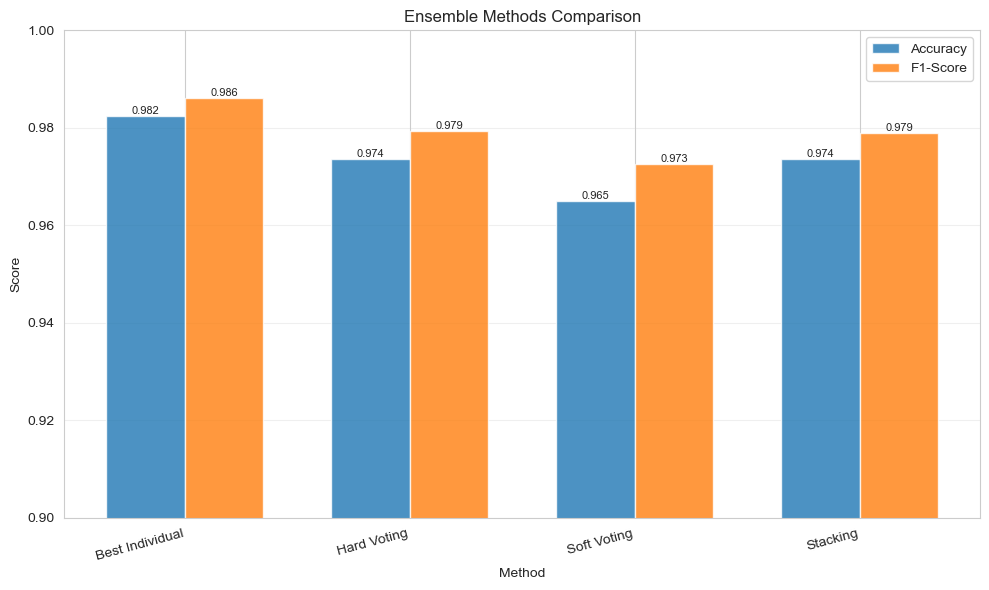


💡 Stacking often achieves the best performance by learning optimal combination!


In [10]:
# Compare all ensemble methods
print("\n\nComprehensive Comparison: All Methods")
print("="*70)

comparison_data = [
    {'Method': 'Best Individual', 'Accuracy': best_individual['Accuracy'], 
     'F1-Score': best_individual['F1-Score']},
    {'Method': 'Hard Voting', 'Accuracy': hard_accuracy, 'F1-Score': hard_f1},
    {'Method': 'Soft Voting', 'Accuracy': soft_accuracy, 'F1-Score': soft_f1},
    {'Method': 'Stacking', 'Accuracy': stacking_accuracy, 'F1-Score': stacking_f1}
]

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

methods = comparison_df['Method']
accuracies = comparison_df['Accuracy']
f1_scores = comparison_df['F1-Score']

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Ensemble Methods Comparison')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')
ax.set_ylim([0.9, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n💡 Stacking often achieves the best performance by learning optimal combination!")

### 4.2 Stacking Regressor

In [11]:
print("Stacking Regressor Demo")
print("="*70)

# Define base models
base_regressors = [
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]

# Meta-model
meta_regressor = Ridge(alpha=1.0, random_state=42)

# Create stacking regressor
stacking_reg = StackingRegressor(
    estimators=base_regressors,
    final_estimator=meta_regressor,
    cv=5,
    n_jobs=-1
)

print("Base Models:")
for name, model in base_regressors:
    print(f"  - {name}: {model.__class__.__name__}")

print(f"\nMeta-Model: {meta_regressor.__class__.__name__}")

# Train
print("\nTraining Stacking Regressor...")
stacking_reg.fit(X_train_reg, y_train_reg)

# Predict
y_pred_stacking_reg = stacking_reg.predict(X_test_reg)

# Evaluate
stacking_mse = mean_squared_error(y_test_reg, y_pred_stacking_reg)
stacking_mae = mean_absolute_error(y_test_reg, y_pred_stacking_reg)
stacking_r2 = r2_score(y_test_reg, y_pred_stacking_reg)

print(f"\nStacking Regressor Results:")
print(f"  R² Score: {stacking_r2:.4f}")
print(f"  MSE:      {stacking_mse:.2f}")
print(f"  MAE:      {stacking_mae:.2f}")

# Compare with voting and best individual
print(f"\n{'='*70}")
print("Regression Ensemble Comparison:")
print(f"{'='*70}")
print(f"Best Individual: {best_individual_reg['Model']} (R² = {best_individual_reg['R² Score']:.4f})")
print(f"Voting:          R² = {voting_r2:.4f}")
print(f"Stacking:        R² = {stacking_r2:.4f}")

if stacking_r2 > voting_r2:
    print("\n✓ Stacking outperforms voting!")
else:
    print("\n⚠ In this case, voting performs similarly to stacking")

Stacking Regressor Demo
Base Models:
  - ridge: Ridge
  - rf: RandomForestRegressor
  - gb: GradientBoostingRegressor

Meta-Model: Ridge

Training Stacking Regressor...

Stacking Regressor Results:
  R² Score: 0.4636
  MSE:      2841.75
  MAE:      42.88

Regression Ensemble Comparison:
Best Individual: Gradient Boosting (R² = 0.4529)
Voting:          R² = 0.4885
Stacking:        R² = 0.4636

⚠ In this case, voting performs similarly to stacking


### 4.3 Stacking with Feature Augmentation

**Advanced Strategy**: Include original features along with base model predictions as input to meta-model.

**Benefits**:
- Meta-model can learn direct feature relationships
- Better performance when base models miss important patterns

**Parameter**: `passthrough=True`

In [12]:
print("Stacking with Feature Augmentation (passthrough=True)")
print("="*70)

# Create stacking with passthrough
stacking_passthrough = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=10000, random_state=42),
    cv=5,
    passthrough=True,  # Include original features
    n_jobs=-1
)

print("Training with passthrough=True...")
print("Meta-model receives: [base_predictions + original_features]\n")

stacking_passthrough.fit(X_train_scaled, y_train)
y_pred_passthrough = stacking_passthrough.predict(X_test_scaled)

passthrough_accuracy = accuracy_score(y_test, y_pred_passthrough)
passthrough_f1 = f1_score(y_test, y_pred_passthrough)

print("Results:")
print(f"  Stacking (standard):    Accuracy = {stacking_accuracy:.4f}, F1 = {stacking_f1:.4f}")
print(f"  Stacking (passthrough): Accuracy = {passthrough_accuracy:.4f}, F1 = {passthrough_f1:.4f}")

if passthrough_accuracy > stacking_accuracy:
    print("\n✓ Passthrough improved performance!")
else:
    print("\n→ Standard stacking is sufficient for this dataset")

print("\n💡 Use passthrough when:")
print("   - Base models might miss important feature relationships")
print("   - Meta-model is complex enough to handle extra features")
print("   - You have sufficient training data to avoid overfitting")

Stacking with Feature Augmentation (passthrough=True)
Training with passthrough=True...
Meta-model receives: [base_predictions + original_features]

Results:
  Stacking (standard):    Accuracy = 0.9737, F1 = 0.9790
  Stacking (passthrough): Accuracy = 0.9737, F1 = 0.9790

→ Standard stacking is sufficient for this dataset

💡 Use passthrough when:
   - Base models might miss important feature relationships
   - Meta-model is complex enough to handle extra features
   - You have sufficient training data to avoid overfitting


## 5. Importance of Model Diversity

### 5.1 Testing Diversity Impact

In [13]:
print("Model Diversity Experiment")
print("="*70)
print("Testing: Similar models vs Diverse models\n")

# Scenario 1: Low diversity (all tree-based)
low_diversity = [
    ('dt1', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('dt2', DecisionTreeClassifier(max_depth=10, random_state=43)),
    ('dt3', DecisionTreeClassifier(max_depth=15, random_state=44))
]

voting_low_div = VotingClassifier(estimators=low_diversity, voting='hard')
voting_low_div.fit(X_train_scaled, y_train)
y_pred_low = voting_low_div.predict(X_test_scaled)
accuracy_low = accuracy_score(y_test, y_pred_low)

print("Low Diversity Ensemble (3 Decision Trees):")
for name, model in low_diversity:
    model.fit(X_train_scaled, y_train)
    ind_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"  {name}: {ind_acc:.4f}")
print(f"  Ensemble: {accuracy_low:.4f}\n")

# Scenario 2: High diversity (different algorithms)
high_diversity = [
    ('lr', LogisticRegression(max_iter=10000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svm', SVC(kernel='rbf', random_state=42))
]

voting_high_div = VotingClassifier(estimators=high_diversity, voting='hard')
voting_high_div.fit(X_train_scaled, y_train)
y_pred_high = voting_high_div.predict(X_test_scaled)
accuracy_high = accuracy_score(y_test, y_pred_high)

print("High Diversity Ensemble (LogReg + RF + SVM):")
for name, model in high_diversity:
    model.fit(X_train_scaled, y_train)
    ind_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"  {name}: {ind_acc:.4f}")
print(f"  Ensemble: {accuracy_high:.4f}\n")

print("="*70)
print(f"Low Diversity Ensemble:  {accuracy_low:.4f}")
print(f"High Diversity Ensemble: {accuracy_high:.4f}")
print(f"Improvement: {(accuracy_high - accuracy_low)*100:+.2f}%")

print("\n💡 Diverse models make different errors → Better ensemble!")

Model Diversity Experiment
Testing: Similar models vs Diverse models

Low Diversity Ensemble (3 Decision Trees):
  dt1: 0.9211
  dt2: 0.9035
  dt3: 0.9123
  Ensemble: 0.9123

High Diversity Ensemble (LogReg + RF + SVM):
  lr: 0.9825
  rf: 0.9561
  svm: 0.9825
  Ensemble: 0.9825

Low Diversity Ensemble:  0.9123
High Diversity Ensemble: 0.9825
Improvement: +7.02%

💡 Diverse models make different errors → Better ensemble!


## 6. Hyperparameter Tuning for Ensembles

### 6.1 Grid Search for Stacking

In [14]:
print("Hyperparameter Tuning for Stacking Ensemble")
print("="*70)

# Create stacking classifier
stacking_tuning = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=10000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=10000, random_state=42),
    cv=3
)

# Define parameter grid
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [10, 20],
    'final_estimator__C': [0.1, 1.0, 10.0]
}

print("Parameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print("\nPerforming Grid Search (this may take a minute)...")

# Grid search
grid_search = GridSearchCV(
    stacking_tuning,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

start_time = time()
grid_search.fit(X_train_scaled, y_train)
grid_time = time() - start_time

print(f"\nGrid Search completed in {grid_time:.2f}s")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred_tuned = grid_search.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"Test Accuracy: {tuned_accuracy:.4f}")
print(f"\n💡 Grid search can significantly improve ensemble performance!")

Hyperparameter Tuning for Stacking Ensemble
Parameter Grid:
  rf__n_estimators: [50, 100]
  rf__max_depth: [10, 20]
  final_estimator__C: [0.1, 1.0, 10.0]

Performing Grid Search (this may take a minute)...

Grid Search completed in 3.62s

Best Parameters:
  final_estimator__C: 1.0
  rf__max_depth: 10
  rf__n_estimators: 50

Best CV Score: 0.9781
Test Accuracy: 0.9737

💡 Grid search can significantly improve ensemble performance!


## 7. Weighted Voting

### Concept

Give more weight to better-performing models:

\[
\hat{y} = \sum_{i=1}^{n} w_i \hat{y}_i
\]

### 7.1 Implementing Weighted Voting

In [15]:
print("Weighted Voting Demo")
print("="*70)

# Train individual models and assess performance
print("Evaluating individual models for weight assignment...\n")

weighted_models = [
    ('lr', LogisticRegression(max_iter=10000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
]

# Calculate weights based on cross-validation accuracy
cv_scores = []
for name, model in weighted_models:
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_score = scores.mean()
    cv_scores.append(cv_score)
    print(f"{name:5} - CV Accuracy: {cv_score:.4f}")

# Convert to weights (normalized)
weights = np.array(cv_scores) / np.sum(cv_scores)

print(f"\nAssigned Weights (normalized):")
for (name, _), weight in zip(weighted_models, weights):
    print(f"  {name}: {weight:.3f}")

# Create voting classifiers with and without weights
voting_unweighted = VotingClassifier(
    estimators=weighted_models,
    voting='soft'
)

voting_weighted = VotingClassifier(
    estimators=weighted_models,
    voting='soft',
    weights=weights
)

# Train and evaluate
voting_unweighted.fit(X_train_scaled, y_train)
voting_weighted.fit(X_train_scaled, y_train)

y_pred_unweighted = voting_unweighted.predict(X_test_scaled)
y_pred_weighted = voting_weighted.predict(X_test_scaled)

acc_unweighted = accuracy_score(y_test, y_pred_unweighted)
acc_weighted = accuracy_score(y_test, y_pred_weighted)

print(f"\n{'='*70}")
print("Results:")
print(f"  Unweighted Voting: {acc_unweighted:.4f}")
print(f"  Weighted Voting:   {acc_weighted:.4f}")
print(f"  Improvement:       {(acc_weighted - acc_unweighted)*100:+.2f}%")

print("\n💡 Weighted voting gives more influence to better models!")

Weighted Voting Demo
Evaluating individual models for weight assignment...

lr    - CV Accuracy: 0.9802
rf    - CV Accuracy: 0.9538
svm   - CV Accuracy: 0.9714

Assigned Weights (normalized):
  lr: 0.337
  rf: 0.328
  svm: 0.334

Results:
  Unweighted Voting: 0.9737
  Weighted Voting:   0.9737
  Improvement:       +0.00%

💡 Weighted voting gives more influence to better models!


## 8. Best Practices and Guidelines

### 8.1 Decision Guide: When to Use Each Method

In [16]:
print("Ensemble Method Selection Guide")
print("="*70)

guide = [
    {
        'Method': 'Voting (Hard)',
        'When to Use': 'Simple classification, diverse models',
        'Pros': 'Fast, simple, robust',
        'Cons': 'Ignores probability information',
        'Best For': 'Quick baseline ensemble'
    },
    {
        'Method': 'Voting (Soft)',
        'When to Use': 'Models output probabilities',
        'Pros': 'Uses probability info, often better',
        'Cons': 'Requires probability calibration',
        'Best For': 'Classification with calibrated models'
    },
    {
        'Method': 'Voting (Regression)',
        'When to Use': 'Regression tasks, diverse models',
        'Pros': 'Simple, reduces variance',
        'Cons': 'Equal weights may not be optimal',
        'Best For': 'Regression with similar model quality'
    },
    {
        'Method': 'Weighted Voting',
        'When to Use': 'Models have different quality',
        'Pros': 'Optimizes contribution of each model',
        'Cons': 'Needs validation set for weights',
        'Best For': 'Unequal model performance'
    },
    {
        'Method': 'Stacking',
        'When to Use': 'Need maximum performance',
        'Pros': 'Learns optimal combination, flexible',
        'Cons': 'Complex, higher overfitting risk',
        'Best For': 'Competitions, critical applications'
    },
    {
        'Method': 'Stacking (passthrough)',
        'When to Use': 'Complex patterns, sufficient data',
        'Pros': 'Meta-model sees original features',
        'Cons': 'More parameters, needs more data',
        'Best For': 'Large datasets with complex relationships'
    },
]

guide_df = pd.DataFrame(guide)
print(guide_df.to_string(index=False))

Ensemble Method Selection Guide
                Method                           When to Use                                 Pros                             Cons                                  Best For
         Voting (Hard) Simple classification, diverse models                 Fast, simple, robust  Ignores probability information                   Quick baseline ensemble
         Voting (Soft)           Models output probabilities  Uses probability info, often better Requires probability calibration     Classification with calibrated models
   Voting (Regression)      Regression tasks, diverse models             Simple, reduces variance Equal weights may not be optimal     Regression with similar model quality
       Weighted Voting         Models have different quality Optimizes contribution of each model Needs validation set for weights                 Unequal model performance
              Stacking              Need maximum performance Learns optimal combination, flexible Compl

### 8.2 Common Pitfalls and Solutions

In [17]:
print("\nCommon Pitfalls and Solutions")
print("="*70)

pitfalls = [
    ("❌ Pitfall", "✓ Solution"),
    ("-" * 40, "-" * 40),
    ("Using similar models (low diversity)", "Mix different algorithm types"),
    ("Not using cross-validation in stacking", "Always use cv parameter (5-10 folds)"),
    ("Overfitting meta-model", "Use simple meta-model (linear/logistic)"),
    ("Ignoring model calibration", "Calibrate probabilities before soft voting"),
    ("Using too many base models", "3-5 diverse models usually sufficient"),
    ("Not standardizing features", "Standardize before training ensembles"),
    ("Equal weights for unequal models", "Use weighted voting or stacking"),
    ("Stacking with leakage", "Never train meta-model on training preds"),
    ("Ignoring computational cost", "Consider inference time for production"),
]

for pitfall, solution in pitfalls:
    print(f"{pitfall:<45} {solution}")


Common Pitfalls and Solutions
❌ Pitfall                                     ✓ Solution
----------------------------------------      ----------------------------------------
Using similar models (low diversity)          Mix different algorithm types
Not using cross-validation in stacking        Always use cv parameter (5-10 folds)
Overfitting meta-model                        Use simple meta-model (linear/logistic)
Ignoring model calibration                    Calibrate probabilities before soft voting
Using too many base models                    3-5 diverse models usually sufficient
Not standardizing features                    Standardize before training ensembles
Equal weights for unequal models              Use weighted voting or stacking
Stacking with leakage                         Never train meta-model on training preds
Ignoring computational cost                   Consider inference time for production


## Summary and Quick Reference

### Quick Reference

```python
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor

# ===== VOTING =====

# Hard Voting (Classification)
voting_hard = VotingClassifier(
    estimators=[('model1', clf1), ('model2', clf2)],
    voting='hard'
)

# Soft Voting (Classification)
voting_soft = VotingClassifier(
    estimators=[('model1', clf1), ('model2', clf2)],
    voting='soft',
    weights=[1, 2]  # Optional weights
)

# Voting Regressor
voting_reg = VotingRegressor(
    estimators=[('model1', reg1), ('model2', reg2)],
    weights=[1, 1]  # Optional
)

# ===== STACKING =====

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('model1', clf1), ('model2', clf2)],
    final_estimator=LogisticRegression(),
    cv=5,  # Cross-validation folds
    stack_method='auto',  # or 'predict_proba', 'decision_function'
    passthrough=False,  # True to include original features
    n_jobs=-1
)

# Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=[('model1', reg1), ('model2', reg2)],
    final_estimator=Ridge(),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Train and predict
model.fit(X_train, y_train)
predictions = model.predict(X_test)
```

### Key Parameters

**VotingClassifier/Regressor**:
- `estimators`: List of (name, model) tuples
- `voting`: 'hard' or 'soft' (classification only)
- `weights`: List of weights for each model
- `n_jobs`: Parallel processing (-1 for all cores)

**StackingClassifier/Regressor**:
- `estimators`: List of (name, base_model) tuples
- `final_estimator`: Meta-model (default: LogisticRegression/RidgeCV)
- `cv`: Cross-validation strategy (int or CV splitter)
- `stack_method`: 'auto', 'predict_proba', 'decision_function', 'predict'
- `passthrough`: Include original features in meta-model input
- `n_jobs`: Parallel processing

### Decision Tree

```
Need Ensemble?
    |
    ├─ Quick baseline → Voting (Soft for classification)
    │
    ├─ Maximum performance needed?
    │   YES → Stacking
    │   NO → Weighted Voting
    │
    ├─ Large dataset + complex patterns?
    │   YES → Stacking with passthrough=True
    │   NO → Standard Stacking
    │
    └─ Models have different quality?
        YES → Weighted Voting or Stacking
        NO → Simple Voting
```

### Performance Guidelines

**Typical Improvements**:
- Voting: 1-3% over best individual model
- Weighted Voting: 1-4% over simple voting
- Stacking: 2-5% over voting (more with good meta-model)

**Computational Cost** (relative to single model):
- Voting: ~N× (N = number of models)
- Stacking: ~N×K + meta-model (K = CV folds)

### Model Selection for Diversity

**Good Combinations**:
- Linear + Tree-based + Kernel (e.g., LogReg + RF + SVM)
- Parametric + Non-parametric (e.g., LogReg + KNN)
- Different principles: Ensemble + Bagging + Boosting

**Avoid**:
- Multiple models of same type (e.g., 3 Random Forests)
- Highly correlated models
- Weak models (<60% accuracy for classification)

### Best Practices Checklist

✓ Use 3-5 diverse base models
✓ Standardize features before training
✓ Use cross-validation (cv=5 or cv=10)
✓ Keep meta-model simple (avoid overfitting)
✓ Calibrate probabilities for soft voting
✓ Validate on separate test set
✓ Consider computational cost for production
✓ Use weights when models have different quality
✓ Try passthrough for complex datasets
✓ Grid search for optimal hyperparameters

### When Ensembles May Not Help

- Very small datasets (<100 samples)
- All base models perform poorly
- Models are highly correlated
- Single model already achieves near-optimal performance
- Strict latency requirements in production

### Further Reading

- **Stacking Paper**: Wolpert (1992) - "Stacked Generalization"
- **Ensemble Methods Book**: Zhou (2012) - "Ensemble Methods: Foundations and Algorithms"
- **Sklearn Documentation**: https://scikit-learn.org/stable/modules/ensemble.html
- **Kaggle Ensembling Guide**: Various competition winning solutions

### Next Steps

- Advanced stacking strategies (multi-level stacking)
- Blending vs Stacking
- Ensemble selection and pruning
- Bayesian Model Averaging
- Neural Network ensembles
- Production deployment of ensembles